#Registration

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import cv2
import imageio
import scipy.ndimage as ndi

In [5]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)


    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()
    print(ssX)
    print(ssY)

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2
        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    #rot =1
    #scale=2
    #translate=3
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [6]:
ct = cv2.imread('jpg/ct.jpg', 0)

In [7]:
ct_points=[]
mri_points=[]

In [8]:
n=int(input())

5


In [9]:
# Define Click Function
def click_event_ct(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        ct_points.append([x,y])

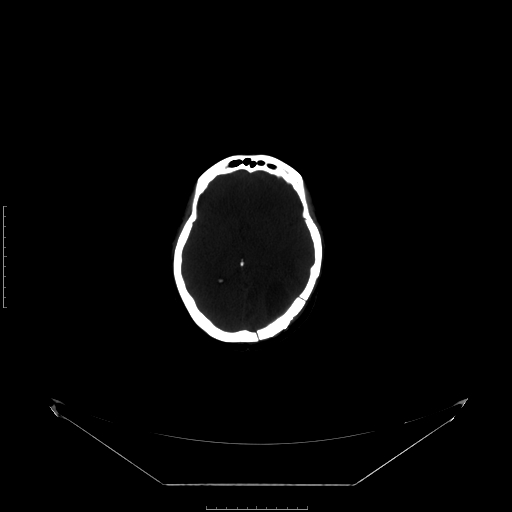

[[249, 154], [174, 253], [242, 342], [324, 245], [276, 282]]

In [20]:
from google.colab.patches import cv2_imshow
cv2_imshow(ct)
cv2.waitKey(0)
cv2.destroyAllWindows()
ct_points

In [21]:
# Define Click Function
def click_event_mri(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        mri_points.append([x,y])

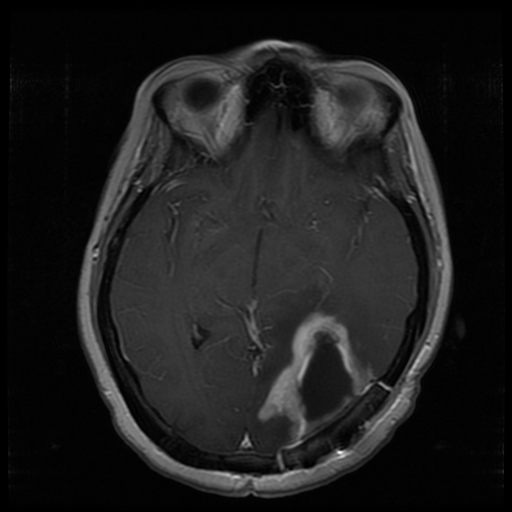

[[277, 42], [82, 271], [254, 495], [451, 261], [314, 315]]

In [23]:
mri_registered = cv2.imread('jpg/mri.jpg',0)
from google.colab.patches import cv2_imshow
cv2_imshow(mri_registered)
cv2.waitKey(0)
cv2.destroyAllWindows()
mri_points

In [24]:
X_pts = np.asarray(ct_points)
Y_pts = np.asarray(mri_points)
print(X_pts)

[[249 154]
 [174 253]
 [242 342]
 [324 245]
 [276 282]]


In [25]:
d,Z_pts,Tform = procrustes(X_pts,Y_pts)

30550.800000000003
174674.0


In [26]:
R = np.eye(3)

In [27]:
Tform

{'rotation': array([[ 0.99988479, -0.01517921],
        [ 0.01517921,  0.99988479]]),
 'scale': 0.4166079895166342,
 'translation': array([136.44564389, 141.63902813])}

In [28]:
R[0:2,0:2] = Tform['rotation']

In [29]:
S = np.eye(3) * Tform['scale'] 
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = Tform['translation']
M = np.dot(np.dot(R,S),t.T).T
h=ct.shape[0]
w=ct.shape[1]
tr_Y_img = cv2.warpAffine(mri_registered,M[0:2,:],(h,w))
cv2.imwrite("jpg/mri_registered.jpg", tr_Y_img) 

True

In [30]:
aY_pts = np.hstack((Y_pts,np.array(([[1,1,1,1,1]])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T

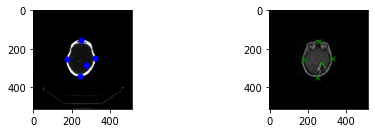

In [31]:
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(ct,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5)
plt.subplot(1,3,3)
plt.imshow(tr_Y_img,cmap=cm.gray)
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=5)
plt.show()

#Fusion

In [32]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [33]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [34]:
class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)
        # return fused_img

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output
        
        
    def _RGB_to_YCbCr(self, img_RGB):
            """
            method which converts an RGB image to YCrCb format
            """
            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
            """
            method which converts a YCrCb image to RGB format
            """
            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
            """
            method which returns True if image is gray, otherwise False
            """
            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):
            """
            method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input)) 

In [35]:
# !pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

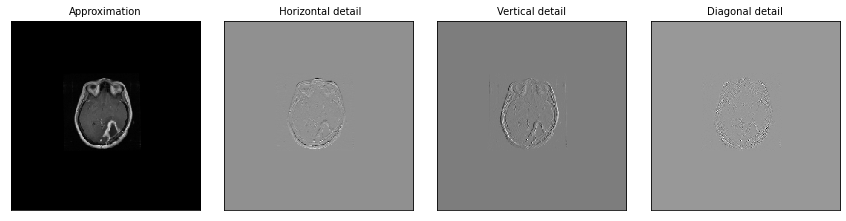

In [37]:
# Load MRI image
mri_image = cv2.imread('jpg/mri_registered.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/mri_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

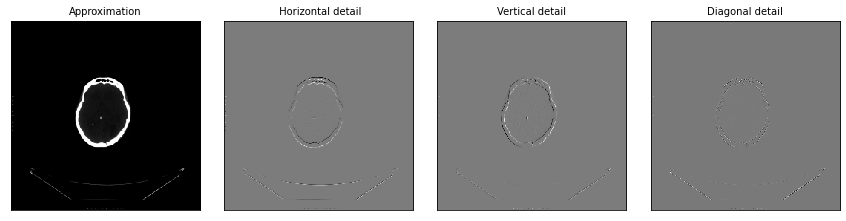

In [38]:
# Load CT Image
ct_image = cv2.imread('jpg/ct.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/ct_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [39]:
# Calling the methods for Siamese on LL Images
input_images = []
mri = cv2.imread('jpg/mri_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_0.jpg', fusion_img)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

True

In [40]:

input_images = []
mri = cv2.imread('jpg/mri_1.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_1.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_1.jpg', fusion_img)

True

In [41]:

input_images = []
mri = cv2.imread('jpg/mri_2.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_2.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_2.jpg', fusion_img)

True

In [42]:

input_images = []
mri = cv2.imread('jpg/mri_3.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_3.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_3.jpg', fusion_img)

True

In [43]:
fusion_0 = cv2.imread('jpg/fusion_0.jpg')
fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

fusion_1 = cv2.imread('jpg/fusion_1.jpg')
fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

fusion_2 = cv2.imread('jpg/fusion_2.jpg')
fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

fusion_3 = cv2.imread('jpg/fusion_3.jpg')
fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))

In [44]:
fusion=pywt.idwt2(coeffs,'haar')
cv2.imwrite('jpg/final_fusion.jpg',fusion)

True

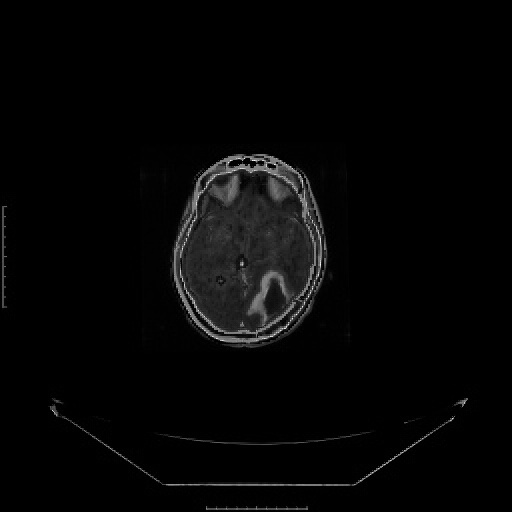

-1

In [45]:
img = cv2.imread('jpg/final_fusion.jpg', 0)
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)

#Segmentation

In [46]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

In [47]:
def ShowImage(title,img,ctype):
    plt.figure(figsize=(10, 10))
    if ctype=='bgr':
        b,g,r = cv2.split(img)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        plt.imshow(rgb_img)
    elif ctype=='hsv':
        rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
        plt.imshow(rgb)
    elif ctype=='gray':
        plt.imshow(img,cmap='gray')
    elif ctype=='rgb':
        plt.imshow(img)
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()

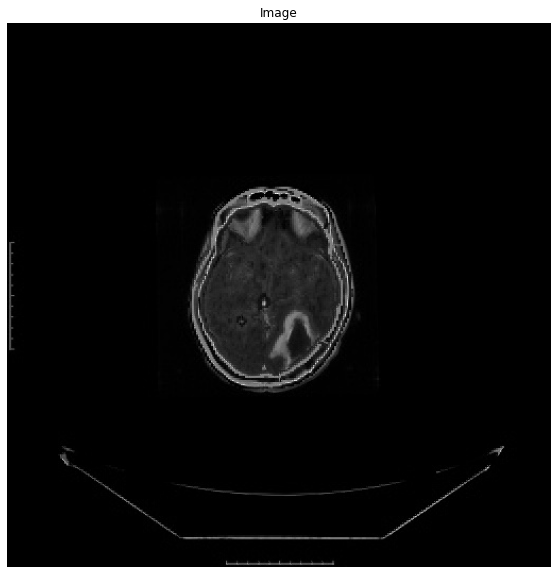

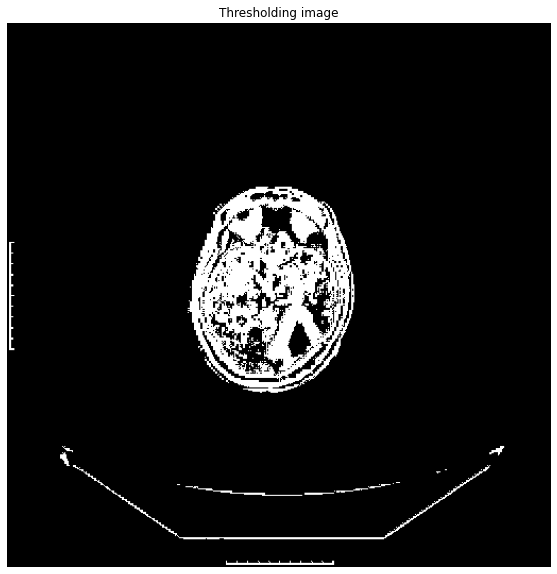

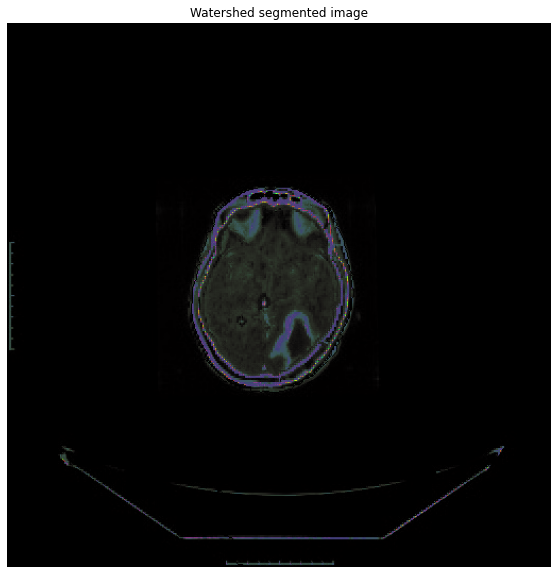

In [48]:
img = cv2.imread("jpg/final_fusion.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Image',gray,'gray')

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Thresholding image',thresh,'gray')

ret, markers = cv2.connectedComponents(thresh)

marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
brain_mask = markers==largest_component

brain_out = img.copy()
brain_out[brain_mask==False] = (0,0,0)

img = cv2.imread("jpg/final_fusion.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
save_to_path="jpg/segmented.jpg"
cv2.imwrite(save_to_path, im1)
ShowImage('Watershed segmented image',im1,'gray')